In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypsa
import seaborn as sb
from glob import glob
import os
import sys
from pathlib import Path
from tqdm import tqdm

In [29]:
results_path = Path('../results/')

In [30]:
networks_list = glob(str(results_path/'**'/'networks'/'*.nc'))
networks_list = [file for file in networks_list if "old_results" not in file]
networks_list

['..\\results\\advanced_nuclear_v3.0\\networks\\illinois_solved.nc',
 '..\\results\\advanced_nuclear_v3.1\\networks\\illinois_solved.nc',
 '..\\results\\cost-2023_growth-0.01_demand-1.40E+08_atb-Moderate_v3.0\\networks\\illinois_solved.nc',
 '..\\results\\cost-2023_growth-0.01_demand-1.85E+08_atb-Moderate_v3.0\\networks\\illinois_solved.nc',
 '..\\results\\cost-2023_growth-0.025_demand-1.40E+08_atb-Moderate_v3.0\\networks\\illinois_solved.nc',
 '..\\results\\cost-2023_growth-0.025_demand-1.85E+08_atb-Moderate_v3.0\\networks\\illinois_solved.nc',
 '..\\results\\cost-2023_growth-0.02_demand-1.40E+08_atb-Moderate_v3.0\\networks\\illinois_solved.nc',
 '..\\results\\cost-2023_growth-0.02_demand-1.85E+08_atb-Moderate_v3.0\\networks\\illinois_solved.nc',
 '..\\results\\cost-2023_growth-0.0_demand-1.40E+08_atb-Moderate_v3.0\\networks\\illinois_solved.nc',
 '..\\results\\cost-2023_growth-0.0_demand-1.85E+08_atb-Moderate_v3.0\\networks\\illinois_solved.nc']

In [31]:
def get_active_units(n):
    c = "StorageUnit"
    df = pd.concat(
        {
            period: n.get_active_assets(c, period) * n.df(c).p_nom_opt
            for period in n.investment_periods
        },
        axis=1,
    )
    df = df.groupby(n.storage_units.carrier).sum()

    c = "Generator"
    df2 = pd.concat(
        {
            period: n.get_active_assets(c, period) * n.df(c).p_nom_opt
            for period in n.investment_periods
        },
        axis=1,
    )
    df2 = df2.groupby(n.generators.carrier).sum()
    df = pd.concat([df, df2])
    
    return df

In [32]:
frames = []
for network in tqdm(networks_list[2:], leave=False):
    parameters = network.split('\\')[2].split('_')
    
    n = pypsa.Network(network)
    
    data = get_active_units(n).T
    
    for i, param in enumerate(parameters[:-1]):
        value = param.split('-')[1]
        if i == 0:
            data['fuel_cost_year'] = value
        elif i==1:
            data['growth'] = value
        elif i==2:
            if float(value) > 180e6:
                data['export'] = 'yes'
            else:
                data['export'] = 'no'
        elif i==3:
            data['atb_case'] = 'value'
    frames.append(data)

 88%|████████▊ | 7/8 [01:20<00:11, 11.29s/it]INFO:pypsa.io:Imported network illinois_solved.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [33]:
cap = pd.concat(frames, axis=0).reset_index()

In [34]:
cap = cap.rename(columns={'index':'year'})

In [35]:
battery_cap = cap.pivot_table(index=['growth','export', 'fuel_cost_year'],
                columns=['year'],
                values='Batteries')

In [36]:
battery_cap_flat =battery_cap.reset_index()

In [37]:
cap['year'] = cap['year'].astype('int')

In [38]:
cap.to_csv('capacity_results.csv')

In [39]:
cap.loc[(cap['year'].isin([2035]))].describe()

carrier,year,Batteries,Biomass,Coal,Natural Gas,Nuclear,Petroleum,Solar,Wind
count,8.0,8.000000,8.0,8.000000e+00,8.000000e+00,8.0,8.0,8.000000,8.000000
mean,2035.0,7545.395530,0.0,4.310600e+03,1.470920e+04,12415.1,0.0,15625.172307,12189.841856
std,0.0,2851.179974,0.0,9.722907e-13,1.944581e-12,0.0,0.0,5554.223904,5153.273886
min,2035.0,4105.421990,0.0,4.310600e+03,1.470920e+04,12415.1,0.0,9342.493968,5218.676911
25%,2035.0,5505.929138,0.0,4.310600e+03,1.470920e+04,12415.1,0.0,10658.932258,8438.100635
50%,2035.0,6985.267461,0.0,4.310600e+03,1.470920e+04,12415.1,0.0,15776.539557,11819.916584
75%,2035.0,9263.307523,0.0,4.310600e+03,1.470920e+04,12415.1,0.0,20468.230177,16499.043150
max,2035.0,12694.240076,0.0,4.310600e+03,1.470920e+04,12415.1,0.0,21849.278874,18724.092528


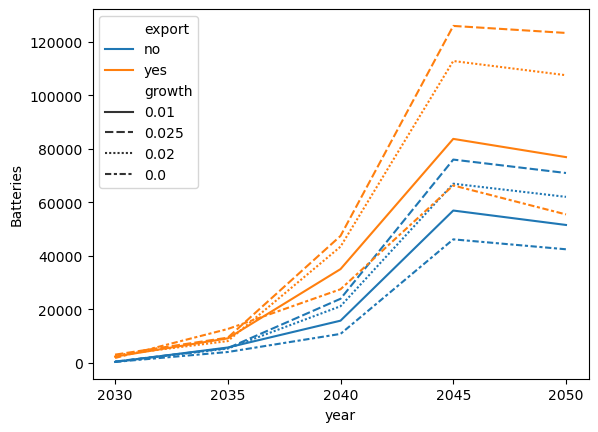

In [40]:
fig, ax = plt.subplots()
sb.lineplot(data=cap, x='year',y='Batteries', hue='export', style='growth')

ax.set_xticks(cap.year.unique())

In [44]:
battery_cap.iloc[:, :-1]

year                                 2030          2035          2040  \
growth export fuel_cost_year                                            
0.0    no     2023             399.262836   4105.421990  10857.916327   
       yes    2023            1868.172250  12694.240076  27527.624315   
0.01   no     2023             399.262836   5784.355814  15800.447848   
       yes    2023            2390.746620   9197.356007  35056.511611   
0.02   no     2023             476.208171   5389.815487  21193.752033   
       yes    2023            2881.914138   8186.179108  43445.657423   
0.025  no     2023             533.282919   5544.633688  23973.356738   
       yes    2023            3118.760169   9461.162072  47445.842481   

year                                   2045  
growth export fuel_cost_year                 
0.0    no     2023             46161.408118  
       yes    2023             66297.503357  
0.01   no     2023             56921.100126  
       yes    2023             83674.919981  
0.02   no     2023             66942.398664  
       yes    2023            112751.386836  
0.025  no     2023             75946.620875  
       yes    2023            125850.211928

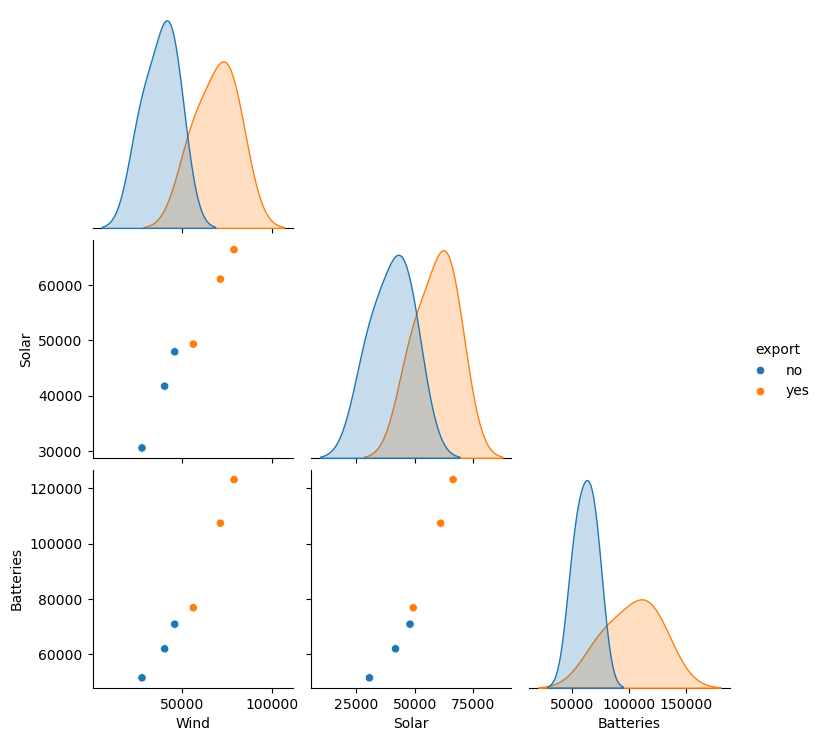

In [15]:
sb.pairplot(data=cap.loc[cap['year']==2050, ['Wind', 'Solar', 'Batteries','export']], hue='export', corner=True)

In [16]:
TECH_ORDER = ['Nuclear',
              'Coal',
              'Natural Gas',
              'Biomass',
              'Petroleum',
              'Wind',
              'Solar',
              ]
def power_by_carrier(n):
    p_by_carrier = n.generators_t.p.T.groupby(
        n.generators.carrier).sum().T 
    
    if not n.storage_units.empty:
        sto = n.storage_units_t.p.T.clip(lower=0).groupby(
            n.storage_units.carrier).sum().T
        p_by_carrier = pd.concat([p_by_carrier, sto], axis=1)
        
    last_cols = [col for col in p_by_carrier.columns if col not in TECH_ORDER]

    p_by_carrier = p_by_carrier[TECH_ORDER+last_cols]

    return p_by_carrier

In [17]:
frames = []
for network in tqdm(networks_list[2:], leave=False):
    parameters = network.split('\\')[2].split('_')
    
    n = pypsa.Network(network)
    
    data = power_by_carrier(n).resample('YE',level='timestep').sum().replace(0, np.nan).dropna(how='all', axis=0).fillna(0)
    
    data.index = data.index.year
    
    for i, param in enumerate(parameters[:-1]):
        value = param.split('-')[1]
        if i == 0:
            data['fuel_cost_year'] = value
        elif i==1:
            data['growth'] = value
        elif i==2:
            if float(value) > 180e6:
                data['export'] = 'yes'
            else:
                data['export'] = 'no'
        elif i==3:
            data['atb_case'] = 'moderate'
    frames.append(data)

 83%|████████▎ | 5/6 [01:00<00:12, 12.23s/it]INFO:pypsa.io:Imported network illinois_solved.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [18]:
gen = pd.concat(frames, axis=0)
gen

carrier,Nuclear,Coal,Natural Gas,Biomass,Petroleum,Wind,Solar,Batteries,fuel_cost_year,growth,export,atb_case
timestep,,,,,,,,,,,,
2030,1.019441e+08,2.383949e+06,3.406796e+06,0.0,0.0,1.976821e+07,1.249858e+07,1.016241e+06,2023,0.01,no,moderate
2035,1.036143e+08,4.263667e+06,5.056543e+06,0.0,0.0,1.955850e+07,1.409874e+07,9.188081e+06,2023,0.01,no,moderate
2040,1.009182e+08,0.000000e+00,3.249170e+06,0.0,0.0,2.750494e+07,2.240411e+07,2.416263e+07,2023,0.01,no,moderate
2045,9.803502e+07,0.000000e+00,0.000000e+00,0.0,0.0,3.603983e+07,2.712397e+07,4.838305e+07,2023,0.01,no,moderate
2050,9.812221e+07,0.000000e+00,0.000000e+00,0.0,0.0,4.689377e+07,2.345466e+07,3.747515e+07,2023,0.01,no,moderate
2030,1.029582e+08,4.263667e+06,8.149442e+06,0.0,0.0,4.549016e+07,2.414706e+07,5.308029e+06,2023,0.01,yes,moderate
2035,1.039431e+08,4.263667e+06,1.295444e+07,0.0,0.0,4.580380e+07,2.677331e+07,1.594093e+07,2023,0.01,yes,moderate
2040,9.972964e+07,0.000000e+00,2.698821e+06,0.0,0.0,5.736820e+07,4.386194e+07,4.251025e+07,2023,0.01,yes,moderate
2045,9.805041e+07,0.000000e+00,0.000000e+00,0.0,0.0,6.330184e+07,5.167378e+07,8.297585e+07,2023,0.01,yes,moderate


In [19]:
gen.to_csv("annual_generation_results.csv")

In [139]:
gen = gen.reset_index()
gen

carrier,timestep,Nuclear,Coal,Natural Gas,Biomass,Petroleum,Wind,Solar,Batteries,fuel_cost_year,growth,export,atb_case
0,2030,1.049315e+08,3.222303e+06,8.167624e+06,0.0,0.0,1.801892e+07,1.659649e+06,2.154967e+06,2018,0.01,no,moderate
1,2035,1.079255e+08,4.263667e+06,2.007739e+07,0.0,0.0,8.284770e+06,1.848658e+06,1.952532e+06,2018,0.01,no,moderate
2,2040,1.016369e+08,0.000000e+00,4.006726e+06,0.0,0.0,2.435938e+07,1.963346e+07,1.922535e+07,2018,0.01,no,moderate
3,2045,9.803149e+07,0.000000e+00,0.000000e+00,0.0,0.0,2.792997e+07,3.041681e+07,4.258172e+07,2018,0.01,no,moderate
4,2050,9.794443e+07,0.000000e+00,0.000000e+00,0.0,0.0,3.337891e+07,3.226193e+07,4.162270e+07,2018,0.01,no,moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2030,1.061454e+08,4.263667e+06,1.766106e+07,0.0,0.0,4.132053e+07,1.560937e+07,1.145763e+03,2023,0,yes,moderate
116,2035,1.060370e+08,4.263667e+06,2.007739e+07,0.0,0.0,3.625430e+07,1.784937e+07,8.063830e+06,2023,0,yes,moderate
117,2040,1.002995e+08,0.000000e+00,3.605942e+06,0.0,0.0,5.105366e+07,3.010957e+07,3.422404e+07,2023,0,yes,moderate
118,2045,9.805979e+07,0.000000e+00,0.000000e+00,0.0,0.0,4.837446e+07,3.855960e+07,5.677830e+07,2023,0,yes,moderate


In [149]:
data = gen.melt(id_vars=['timestep','export','growth'],
                value_vars=['Batteries','Coal','Natural Gas','Nuclear','Solar','Wind'])

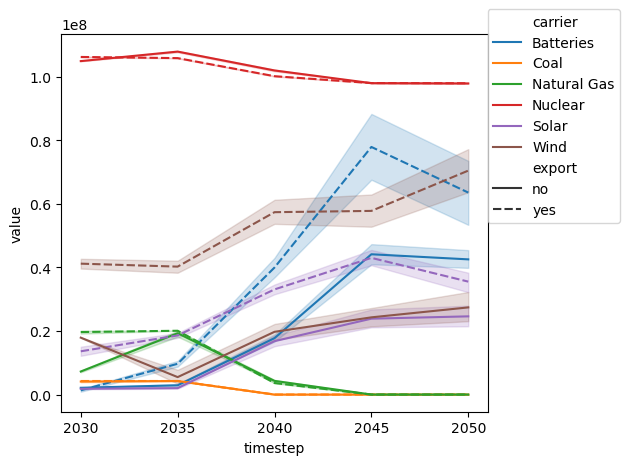

In [157]:
ax = sb.lineplot(data=data, x='timestep', y='value', hue='carrier', style='export')
ax.legend(loc=(1,0.5))
ax.set_xticks(data['timestep'].unique())
plt.tight_layout()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


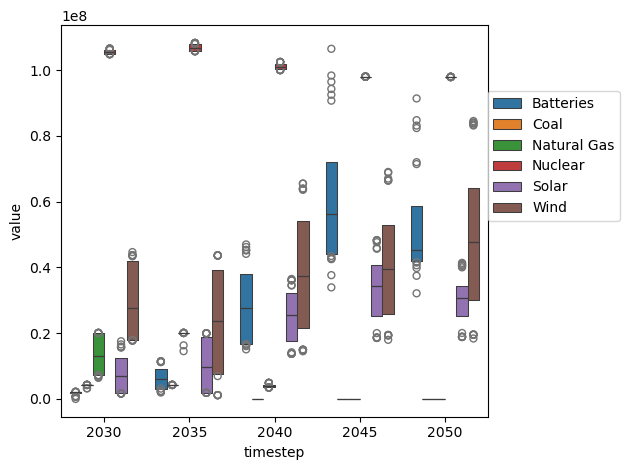

In [151]:
ax = sb.boxenplot(data=data, x='timestep', y='value', hue='carrier')
ax.legend(loc=(1,0.5))
plt.tight_layout()